# SoccerCPD

이 Jupyter Notebook은 **[SoccerCPD](https://github.com/hyunsungkim-ds/soccercpd)** 프로젝트를 기반으로 한 실습자료입니다.  
축구 이벤트 데이터에서 전술 변화를 포착하는 방법을 단계별로 경험할 수 있도록 구성되어 있습니다.

**주요 내용**
- 이벤트 데이터 전처리 및 특성 추출
- CPD 알고리즘을 활용한 경기 내 전술 변화 탐지
- 실제 축구 데이터 기반 시각화 및 분석

## Formation Clustering
Section 4.3 in the paper

In [ ]:
!git clone https://github.com/narame7/UOS-FootballDataAnalytics-Tutorial


In [ ]:
%cd '/content/UOS-FootballDataAnalytics-Tutorial/Week 14/notebooks'

In [1]:
import os
wd = os.path.normpath(os.getcwd() + '/..')
os.chdir(wd)
os.getcwd()

'/home/2025FDA/Week 14'

In [86]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import itertools
import seaborn as sns
from collections import Counter
import matplotlib.image as mpimg
from joblib import Parallel, delayed
from scipy.spatial import distance_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
from src.myconstants import *
from src.rolerep import RoleRep

pd.set_option('display.width', 250)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 20)
plt.rcParams['font.family'] = 'Arial'

In [ ]:
from src.myconstants import *
from src.form_manager import FormManager

### Calculating the pairwise distances between formation graphs

In [4]:
form_periods = pd.read_pickle(f'data/form_periods.pkl')
form_periods

,activity_id,session,form_period,start_dt,end_dt,duration,coords,edge_mat,cluster,formation
0,12864,1,1,2020-01-01 14:00:00,2020-01-01 14:47:00,2820.0,"[[-719.0, 1625.0], [-1342.0, 660.0], [948.0, 1...","[[0.0, 0.977, 0.955, 0.2, 0.023, 0.828, 0.257,...",20,442
1,12868,1,1,2020-01-01 14:00:00,2020-01-01 14:47:00,2820.0,"[[-833.0, -1647.0], [14.0, 181.0], [-369.0, -1...","[[0.0, 0.338, 0.684, 0.994, 0.165, 0.042, 0.15...",5,4132
2,12868,2,2,2020-01-01 15:02:00,2020-01-01 15:50:00,2880.0,"[[-933.0, -1939.0], [-106.0, 618.0], [-231.0, ...","[[0.0, 0.164, 0.86, 0.993, 0.131, 0.036, 0.237...",20,442
3,12870,1,1,2020-01-01 13:30:00,2020-01-01 14:19:00,2940.0,"[[-1408.0, 43.0], [460.0, -1087.0], [-285.0, 5...","[[0.0, 0.22, 0.871, 0.098, 0.367, 0.962, 0.328...",12,352
4,12870,2,2,2020-01-01 14:33:00,2020-01-01 15:23:00,3000.0,"[[-1282.0, -147.0], [290.0, -888.0], [-209.0, ...","[[0.0, 0.416, 0.886, 0.054, 0.192, 0.998, 0.27...",-1,others
...,...,...,...,...,...,...,...,...,...,...
861,9064,2,3,2020-01-01 16:32:00,2020-01-01 16:51:00,1140.0,"[[-1589.0, 486.0], [-1684.0, -710.0], [-34.0, ...","[[0.0, 0.984, 0.515, 0.04, 0.009, 0.025, 0.813...",20,442
862,9281,1,1,2020-01-01 15:00:00,2020-01-01 15:47:00,2820.0,"[[-1478.0, 113.0], [-1176.0, -1051.0], [1666.0...","[[0.0, 0.982, 0.015, 0.022, 0.016, 0.191, 0.98...",0,343
863,9281,2,2,2020-01-01 16:03:00,2020-01-01 16:51:00,2880.0,"[[-1270.0, -89.0], [-1128.0, -1051.0], [1465.0...","[[0.0, 0.94, 0.052, 0.025, 0.047, 0.184, 0.974...",20,442
864,9285,1,1,2020-01-01 14:01:00,2020-01-01 14:48:00,2820.0,"[[-674.0, 1815.0], [-1457.0, 614.0], [-1564.0,...","[[0.0, 0.992, 0.237, 0.295, 0.148, 0.748, 0.20...",18,4231


In [25]:
cluster_to_formation = dict(zip(form_periods['cluster'], form_periods['formation']))
cluster_to_formation

{20: '442',
 5: '4132',
 12: '352',
 -1: 'others',
 0: '343',
 26: '4231',
 19: '4231',
 18: '4231',
 16: '433',
 23: '4231',
 30: '433'}

In [5]:
def compute_delaunay_dists(i, n):
    form1 = form_periods.iloc[i]
    dist_row = []
    for j in range(n):
        form2 = form_periods.iloc[j]
        cost_mat = distance_matrix(form1['coords'], form2['coords'])
        _, perm = linear_sum_assignment(cost_mat)
        edge_mat1 = form1['edge_mat']
        edge_mat2 = form2['edge_mat'][perm][:, perm]
        dist_row.append(np.abs(edge_mat1 - edge_mat2).sum())
    return i, dist_row

In [ ]:
#약 4분 정도 소요
n = len(form_periods)
dist_rows = Parallel(n_jobs=-1)(delayed(compute_delaunay_dists)(i, n) for i in range(n))
dist_mat = np.zeros((n, n))
for i, dist_row in dist_rows:
    dist_mat[i] = dist_row
dist_mat

array([[ 0.   ,  8.14 ,  5.69 , ...,  4.42 ,  9.074,  9.928],
       [ 8.14 ,  0.   ,  6.742, ...,  9.808,  6.302, 10.644],
       [ 5.69 ,  6.742,  0.   , ...,  6.434,  6.36 ,  7.082],
       ...,
       [ 4.42 ,  9.808,  6.434, ...,  0.   , 16.838, 15.588],
       [ 9.074,  6.302,  6.36 , ..., 16.838,  0.   ,  6.846],
       [ 9.928, 10.644,  7.082, ..., 15.588,  6.846,  0.   ]])

### Initial clustering based on the distance matrix

In [8]:
dist_mat = pd.read_csv('data/form_dist_mat.csv', header=None).values
dist_mat

array([[ 0.   ,  8.14 ,  5.69 , ...,  4.42 ,  9.074,  9.928],
       [ 8.14 ,  0.   ,  6.742, ...,  9.808,  6.302, 10.644],
       [ 5.69 ,  6.742,  0.   , ...,  6.434,  6.36 ,  7.082],
       ...,
       [ 4.42 ,  9.808,  6.434, ...,  0.   , 16.838, 15.588],
       [ 9.074,  6.302,  6.36 , ..., 16.838,  0.   ,  6.846],
       [ 9.928, 10.644,  7.082, ..., 15.588,  6.846,  0.   ]])

In [ ]:
n_clusters = 18
model = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='average')
model = model.fit(dist_mat)
counter = Counter(model.labels_)
outliers = []
for cluster, count in counter.items():
    if count < 15:
        outliers.append(cluster)
form_periods['cluster'] = np.where(np.isin(model.labels_, outliers), -1, model.labels_)
counts = form_periods['cluster'].value_counts()
counts

/opt/conda/envs/cpd/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


cluster
 1     338
 0     188
 16    143
 12    106
 5      50
-1      41
Name: count, dtype: int64

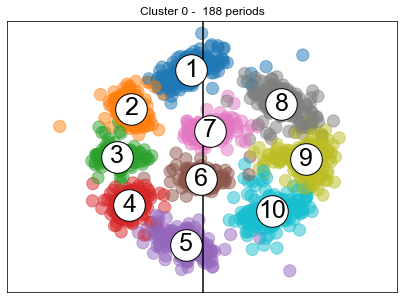

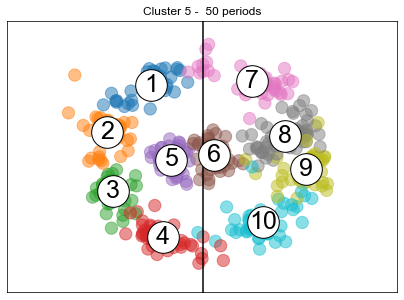

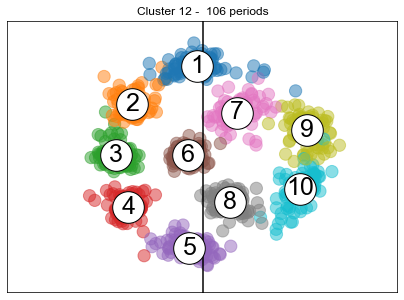

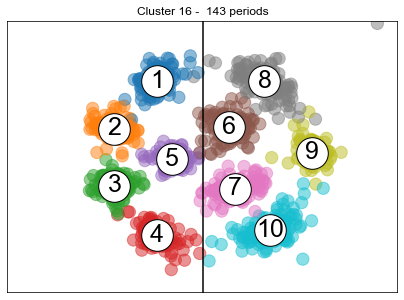

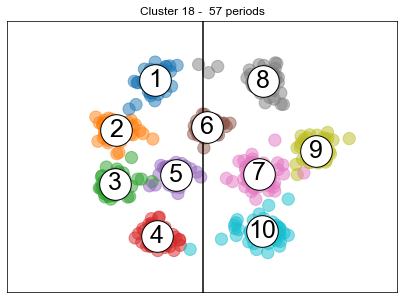

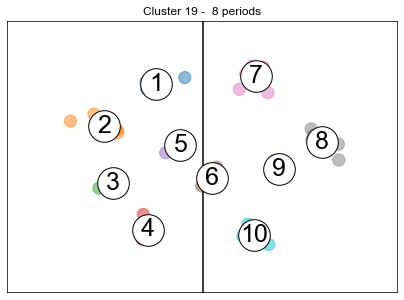

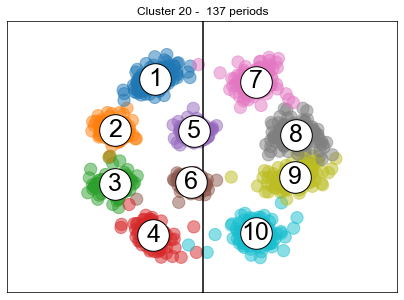

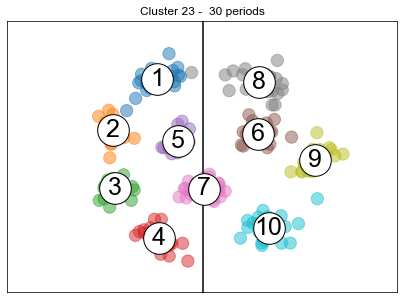

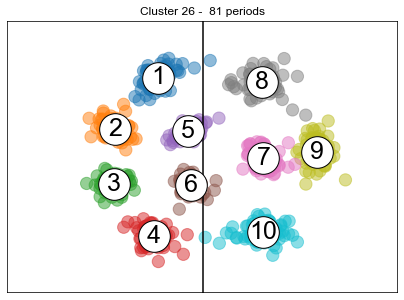

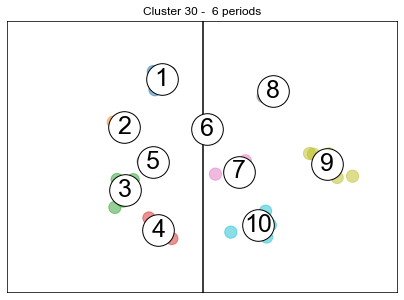

In [ ]:
fm = FormManager(form_periods)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans'] # 혹은 'Liberation Sans'
fm.visualize(group_type=LABEL_CLUSTER, ignore_outliers=True)

In [11]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram    
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, color_threshold=0, **kwargs)
    ax = plt.gca()
    ax.tick_params(axis='x', which='major', labelsize=15)

/opt/conda/envs/cpd/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


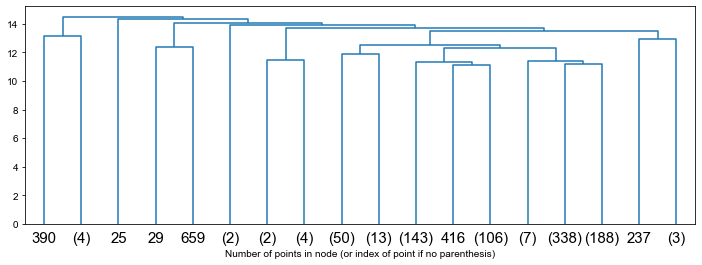

In [ ]:
plt.figure(figsize=(12, 4))
model = AgglomerativeClustering(
    n_clusters=None, metric='precomputed', linkage='average', distance_threshold=0
)
model.fit(dist_mat)
plot_dendrogram(model, truncate_mode='lastp', p=n_clusters)
plt.xlabel("Number of points in node (or index of point if no parenthesis)")
plt.show()

### Assigning a formation label per cluster

In [17]:
clus_to_form = {
    0: '343', 12: '352', 20: '442', 16: '433', 30: '433', 5: '4132', 
    18: '4231', 19: '4231', 23: '4231', 26: '4231', -1: 'others'
}
form_periods[LABEL_FORMATION] = form_periods[LABEL_CLUSTER].apply(lambda x: clus_to_form[x])
form_periods.to_pickle('data/form_periods.pkl')
form_periods

,activity_id,session,form_period,start_dt,end_dt,duration,coords,edge_mat,cluster,formation
0,12864,1,1,2020-01-01 14:00:00,2020-01-01 14:47:00,2820.0,"[[-719.0, 1625.0], [-1342.0, 660.0], [948.0, 1...","[[0.0, 0.977, 0.955, 0.2, 0.023, 0.828, 0.257,...",20,442
1,12868,1,1,2020-01-01 14:00:00,2020-01-01 14:47:00,2820.0,"[[-833.0, -1647.0], [14.0, 181.0], [-369.0, -1...","[[0.0, 0.338, 0.684, 0.994, 0.165, 0.042, 0.15...",5,4132
2,12868,2,2,2020-01-01 15:02:00,2020-01-01 15:50:00,2880.0,"[[-933.0, -1939.0], [-106.0, 618.0], [-231.0, ...","[[0.0, 0.164, 0.86, 0.993, 0.131, 0.036, 0.237...",20,442
3,12870,1,1,2020-01-01 13:30:00,2020-01-01 14:19:00,2940.0,"[[-1408.0, 43.0], [460.0, -1087.0], [-285.0, 5...","[[0.0, 0.22, 0.871, 0.098, 0.367, 0.962, 0.328...",12,352
4,12870,2,2,2020-01-01 14:33:00,2020-01-01 15:23:00,3000.0,"[[-1282.0, -147.0], [290.0, -888.0], [-209.0, ...","[[0.0, 0.416, 0.886, 0.054, 0.192, 0.998, 0.27...",-1,others
...,...,...,...,...,...,...,...,...,...,...
861,9064,2,3,2020-01-01 16:32:00,2020-01-01 16:51:00,1140.0,"[[-1589.0, 486.0], [-1684.0, -710.0], [-34.0, ...","[[0.0, 0.984, 0.515, 0.04, 0.009, 0.025, 0.813...",20,442
862,9281,1,1,2020-01-01 15:00:00,2020-01-01 15:47:00,2820.0,"[[-1478.0, 113.0], [-1176.0, -1051.0], [1666.0...","[[0.0, 0.982, 0.015, 0.022, 0.016, 0.191, 0.98...",0,343
863,9281,2,2,2020-01-01 16:03:00,2020-01-01 16:51:00,2880.0,"[[-1270.0, -89.0], [-1128.0, -1051.0], [1465.0...","[[0.0, 0.94, 0.052, 0.025, 0.047, 0.184, 0.974...",20,442
864,9285,1,1,2020-01-01 14:01:00,2020-01-01 14:48:00,2820.0,"[[-674.0, 1815.0], [-1457.0, 614.0], [-1564.0,...","[[0.0, 0.992, 0.237, 0.295, 0.148, 0.748, 0.20...",18,4231


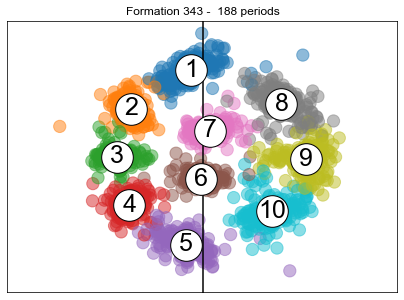

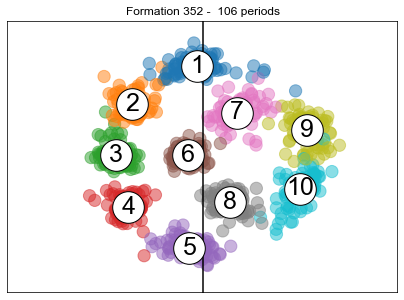

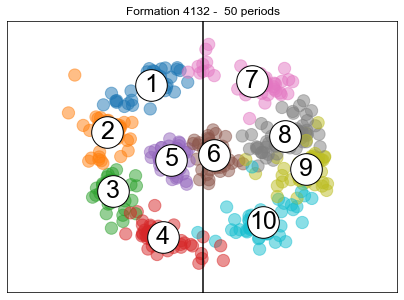

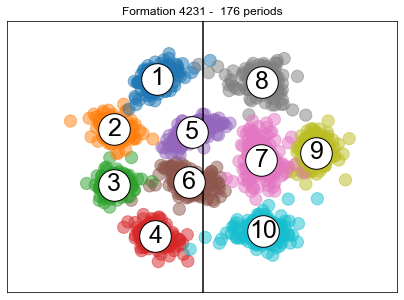

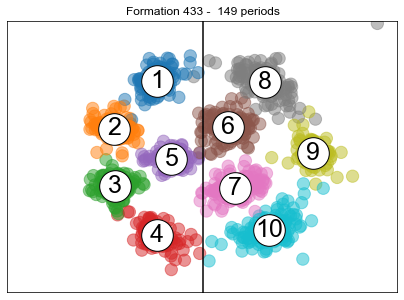

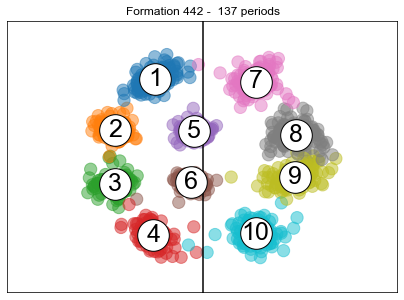

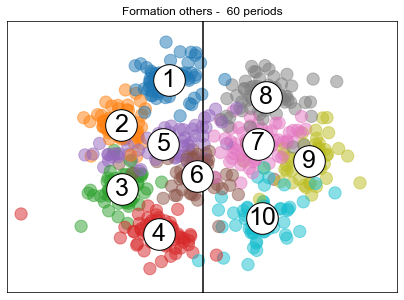

In [19]:
fm.visualize(group_type=LABEL_FORMATION, save=True)

In [20]:
total_dur = form_periods[LABEL_DURATION].sum()
form_durs = form_periods.groupby(LABEL_FORMATION)[LABEL_DURATION].sum()

counts = form_periods[LABEL_FORMATION].value_counts()
form_props = (form_durs / total_dur).round(4)
form_mean_durs = (form_durs / form_periods[LABEL_FORMATION].value_counts()).round(1)

counts.name = 'count'
form_props.name = 'proportion'
form_mean_durs.name = 'mean_dur'

pd.concat([counts, form_props, form_mean_durs], axis=1)

,count,proportion,mean_dur
formation,,,
343,188,0.2233,2770.5
4231,176,0.2091,2771.1
433,149,0.1735,2716.2
442,137,0.1633,2780.4
352,106,0.1222,2689.1
others,60,0.0506,1967.3
4132,50,0.0579,2699.2


## Role Labeling
Section 5.3 in the paper

In [28]:
role_records = pd.read_csv('data/role_records.csv', header=0, encoding='utf-8-sig')

Roles aligned for formation '343'
Roles aligned for formation '352'
Roles aligned for formation '4132'
Roles aligned for formation '4231'
Roles aligned for formation '433'
Roles aligned for formation '442'
Roles aligned for formation 'others'


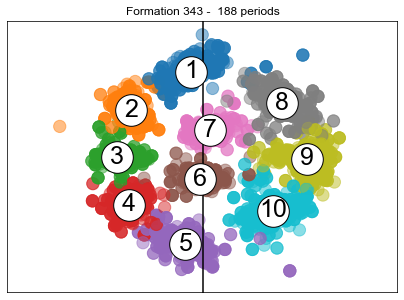

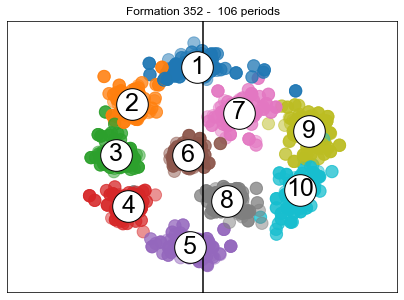

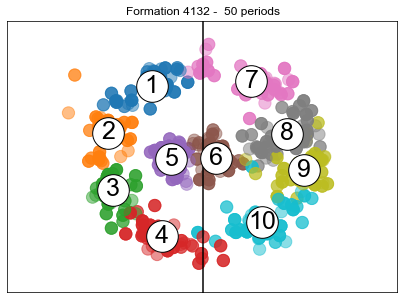

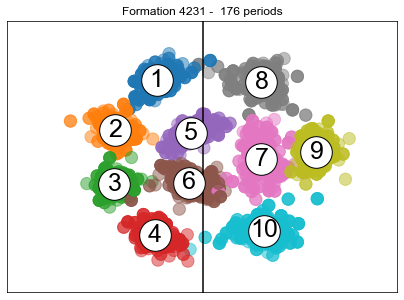

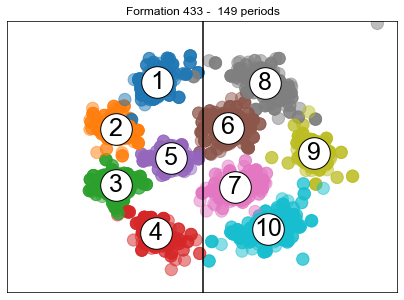

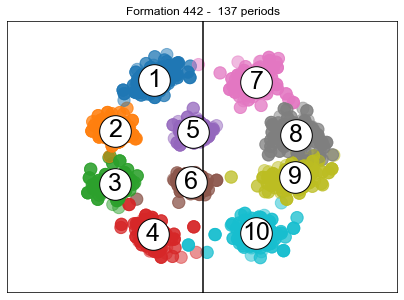

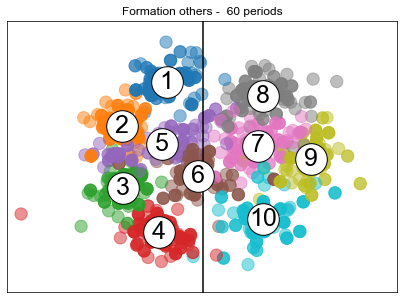

In [29]:
fm = FormManager(form_periods, role_records)
fm.align()
fm.visualize()

In [30]:
role_labels = pd.DataFrame([
    ['343', 'LWB', 'LCB', 'CB', 'RCB', 'RWB', 'RCM', 'LCM', 'LM', 'CF', 'RM'],
    ['352', 'LWB', 'LCB', 'CB', 'RCB', 'RWB', 'CDM', 'LCM', 'RCM', 'LCF', 'RCF'],
    ['442', 'LB', 'LCB', 'RCB', 'RB', 'LCM', 'RCM', 'LM', 'LCF', 'RCF', 'RM'],
    ['4231', 'LB', 'LCB', 'RCB', 'RB', 'LDM', 'RDM', 'CAM', 'LM', 'CF', 'RM'],
    ['433', 'LB', 'LCB', 'RCB', 'RB', 'CDM', 'LCM', 'RCM', 'LM', 'CF', 'RM'],
    ['4132', 'LB', 'LCB', 'RCB', 'RB', 'CDM', 'CAM', 'LM', 'LCF', 'RCF', 'RM'],
    ['others'] + [f'R{i}' for i in list(range(1, 11))]
], columns=[LABEL_FORMATION] + list(range(1, 11))).set_index(LABEL_FORMATION)
role_labels

,1,2,3,4,5,6,7,8,9,10
formation,,,,,,,,,,
343,LWB,LCB,CB,RCB,RWB,RCM,LCM,LM,CF,RM
352,LWB,LCB,CB,RCB,RWB,CDM,LCM,RCM,LCF,RCF
442,LB,LCB,RCB,RB,LCM,RCM,LM,LCF,RCF,RM
4231,LB,LCB,RCB,RB,LDM,RDM,CAM,LM,CF,RM
433,LB,LCB,RCB,RB,CDM,LCM,RCM,LM,CF,RM
4132,LB,LCB,RCB,RB,CDM,CAM,LM,LCF,RCF,RM
others,R1,R2,R3,R4,R5,R6,R7,R8,R9,R10


In [31]:
def give_role_labels(role_records, role_labels):
    formation = role_records[LABEL_FORMATION].iloc[0]
    role_dict = role_labels.loc[formation].to_dict()
    role_records.loc[role_records.index, LABEL_ALIGNED_ROLE] = (
        role_records.loc[role_records.index, LABEL_ALIGNED_ROLE].replace(role_dict)
    )
    return role_records

In [32]:
role_records = fm.role_records.groupby(LABEL_FORMATION).apply(give_role_labels, role_labels)
role_records

activity_id  player_period  form_period  role_period  session             start_dt               end_dt  duration  player_id  squad_num player_name  base_role       x       y formation aligned_role
formation                                                                                                                                                                                                             
343       209           2071              1            1            1        1  2020-01-01 15:00:00  2020-01-01 15:49:00      2940       1851          4         P04          1 -1007.0   846.0       343          LCB
          210           2071              1            1            1        1  2020-01-01 15:00:00  2020-01-01 15:49:00      2940       1853          6         P06          2    59.0  -574.0       343          RCM
          211           2071              1            1            1        1  2020-01-01 15:00:00  2020-01-01 15:49:00      2916       1855          8         P08          3  -163.0   587.0       343          LCM
          212           2071              1            1            1        1  2020-01-01 15:00:00  2020-01-01 15:49:00      2940       1857         10         P10          4   921.0   774.0       343           LM
          213           2071              1            1            1        1  2020-01-01 15:00:00  2020-01-01 15:38:41      2321       1858         11         P11          5  1689.0   194.0       343           CF
...                      ...            ...          ...          ...      ...                  ...                  ...       ...        ...        ...         ...        ...     ...     ...       ...          ...
others    21123        22875              4            3            6        2  2020-01-01 16:51:20  2020-01-01 16:58:00       400       5781         19         P19          5   367.0  -385.0    others           R6
          21124        22875              4            3            6        2  2020-01-01 16:51:20  2020-01-01 16:58:00       400       5204         20         P20          7 -1087.0  -359.0    others           R3
          21125        22875              4            3            6        2  2020-01-01 16:51:20  2020-01-01 16:58:00       400       5450         23         P23          3  1264.0  -275.0    others           R9
          21126        22875              4            3            6        2  2020-01-01 16:51:20  2020-01-01 16:58:00       400       4643         33         P33          9 -1185.0   420.0    others           R2
          21127        22875              4            3            6        2  2020-01-01 16:51:20  2020-01-01 16:58:00       400      11817         62         P62         10 -2787.0 -1260.0    others           R4

[21128 rows x 16 columns]

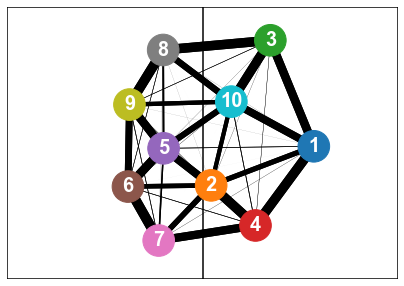

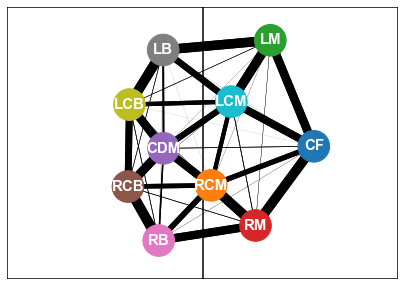

In [33]:
### Visualizing roles with soccer-specific labels
# Choose an activity and a formation period
activity_id = 1879
form_period = 1

form_idx = form_periods[
    (form_periods[LABEL_ACTIVITY_ID] == activity_id) &
    (form_periods[LABEL_FORM_PERIOD] == form_period)
].index[0]
mean_coords = form_periods.at[form_idx, LABEL_COORDS]
mean_edge_mat = form_periods.at[form_idx, LABEL_EDGE_MAT]

unit_role_records = role_records[
    (role_records[LABEL_ACTIVITY_ID] == activity_id) &
    (role_records[LABEL_FORM_PERIOD] == form_period)
]
labels = dict(zip(unit_role_records[LABEL_BASE_ROLE], unit_role_records[LABEL_ALIGNED_ROLE]))

# Without aligned role labels
FormManager.visualize_single_graph(mean_coords, mean_edge_mat)

# With aligned role labels
FormManager.visualize_single_graph(mean_coords, mean_edge_mat, labels)
# plt.savefig(f'img/pos_annot_normal.png', bbox_inches='tight')

(-3000.0, 3000.0, -3000.0, 3000.0)

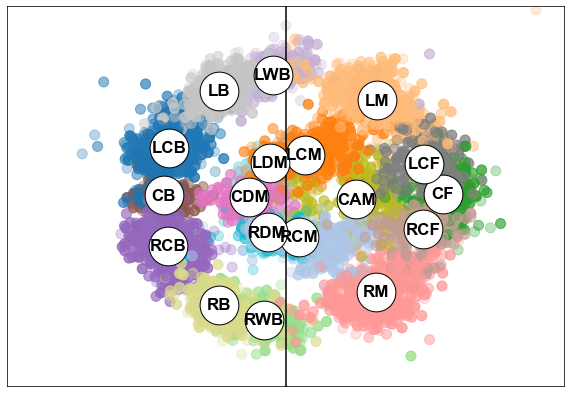

In [34]:
ordinary_role_records = role_records[role_records[LABEL_FORMATION] != 'others']
x = ordinary_role_records[LABEL_X]
y = ordinary_role_records[LABEL_Y]
ordinary_roles = ordinary_role_records[LABEL_ALIGNED_ROLE].unique()
role_to_color = dict(zip(ordinary_roles, np.arange(len(ordinary_roles))))
colors = ordinary_role_records[LABEL_ALIGNED_ROLE].apply(lambda x: role_to_color[x])

plt.figure(figsize=(10, 7))
plt.scatter(x, y, s=100, c=colors, alpha=0.3, cmap='tab20', zorder=0)

mean_coords = ordinary_role_records.groupby(LABEL_ALIGNED_ROLE)[[LABEL_X, LABEL_Y]].mean()
plt.scatter(mean_coords[LABEL_X], mean_coords[LABEL_Y], s=1500, c='w', edgecolors='k', zorder=1)
for r in mean_coords.index:
    plt.annotate(r, xy=mean_coords.loc[r], ha='center', va='center', fontsize=17, fontweight='bold', zorder=2)

xlim = 3000
ylim = 3000
plt.xlim(-xlim, xlim)
plt.ylim(-ylim, ylim)
plt.vlines([-xlim, 0, xlim], ymin=-ylim, ymax=ylim, color='k', zorder=0)
plt.hlines([-ylim, ylim], xmin=-xlim, xmax=xlim, color='k', zorder=0)
plt.axis('off')

# plt.savefig(f'img/pos_scatter.png', bbox_inches='tight')

In [ ]:
### Assigning domain-specific role labels for 'others' formations

role_distns = ordinary_role_records.groupby(LABEL_ALIGNED_ROLE).apply(
    RoleRep.estimate_mvn, col_x=LABEL_X, col_y=LABEL_Y, filter=False
)
role_distns

aligned_role
CAM    <scipy.stats._multivariate.multivariate_normal...
CB     <scipy.stats._multivariate.multivariate_normal...
CDM    <scipy.stats._multivariate.multivariate_normal...
CF     <scipy.stats._multivariate.multivariate_normal...
LB     <scipy.stats._multivariate.multivariate_normal...
LCB    <scipy.stats._multivariate.multivariate_normal...
LCF    <scipy.stats._multivariate.multivariate_normal...
LCM    <scipy.stats._multivariate.multivariate_normal...
LDM    <scipy.stats._multivariate.multivariate_normal...
LM     <scipy.stats._multivariate.multivariate_normal...
LWB    <scipy.stats._multivariate.multivariate_normal...
RB     <scipy.stats._multivariate.multivariate_normal...
RCB    <scipy.stats._multivariate.multivariate_normal...
RCF    <scipy.stats._multivariate.multivariate_normal...
RCM    <scipy.stats._multivariate.multivariate_normal...
RDM    <scipy.stats._multivariate.multivariate_normal...
RM     <scipy.stats._multivariate.multivariate_normal...
RWB    <scipy.stat

In [37]:
def hungarian(unit_role_records):
    cost_mat = unit_role_records[ordinary_roles].values
    _, col_idx = linear_sum_assignment(cost_mat)
    role_records.loc[unit_role_records.index, LABEL_ALIGNED_ROLE] = ordinary_roles[col_idx]
    # return unit_role_records[HEADER_ROLE_RECORDS + [LABEL_ALIGNED_ROLE]]

In [38]:
other_form_periods = form_periods[form_periods[LABEL_FORMATION] == 'others']
other_role_records = pd.merge(role_records, other_form_periods[[LABEL_ACTIVITY_ID, LABEL_FORM_PERIOD]])

cost_df = role_distns.apply(
    lambda n: pd.Series(-np.log(n.pdf(other_role_records[[LABEL_X, LABEL_Y]])))
).transpose()
other_role_records = pd.concat([other_role_records, cost_df], axis=1)
other_role_records.index = role_records[role_records[LABEL_FORMATION] == 'others'].index
other_role_records.groupby([LABEL_ACTIVITY_ID, LABEL_ROLE_PERIOD]).apply(hungarian)

role_records[role_records[LABEL_FORMATION] == 'others']

activity_id  player_period  form_period  role_period  session             start_dt               end_dt  duration  player_id  squad_num player_name  base_role       x       y formation aligned_role
formation                                                                                                                                                                                                             
others    59            1882              1            1            1        1  2020-01-01 15:00:00  2020-01-01 15:24:10      1450       1849          2         P02          1  -603.0  1789.0    others           LB
          60            1882              1            1            1        1  2020-01-01 15:00:00  2020-01-01 15:24:10      1450       1850          3         P03          2 -1342.0  -659.0    others          RCB
          61            1882              1            1            1        1  2020-01-01 15:00:00  2020-01-01 15:24:10      1450       1851          4         P04          3 -1536.0   642.0    others          LCB
          62            1882              1            1            1        1  2020-01-01 15:00:00  2020-01-01 15:24:10      1450       1855          8         P08          4  -494.0   546.0    others          LDM
          63            1882              1            1            1        1  2020-01-01 15:00:00  2020-01-01 15:24:10      1450       1857         10         P10          5  1218.0   231.0    others          LCF
...                      ...            ...          ...          ...      ...                  ...                  ...       ...        ...        ...         ...        ...     ...     ...       ...          ...
          21123        22875              4            3            6        2  2020-01-01 16:51:20  2020-01-01 16:58:00       400       5781         19         P19          5   367.0  -385.0    others          RCM
          21124        22875              4            3            6        2  2020-01-01 16:51:20  2020-01-01 16:58:00       400       5204         20         P20          7 -1087.0  -359.0    others          RCB
          21125        22875              4            3            6        2  2020-01-01 16:51:20  2020-01-01 16:58:00       400       5450         23         P23          3  1264.0  -275.0    others          RCF
          21126        22875              4            3            6        2  2020-01-01 16:51:20  2020-01-01 16:58:00       400       4643         33         P33          9 -1185.0   420.0    others           CB
          21127        22875              4            3            6        2  2020-01-01 16:51:20  2020-01-01 16:58:00       400      11817         62         P62         10 -2787.0 -1260.0    others          LCB

[1289 rows x 16 columns]

Activity ID: 6736, Formation period: 1


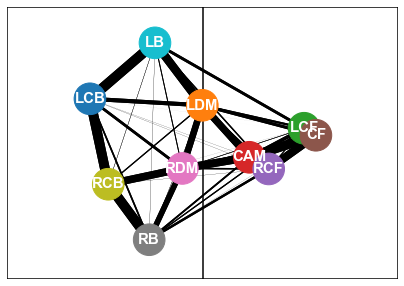

In [39]:
# Visualize a formation period whose formation is classified as 'others'

i = 47  # Choose from 0 to 59
form_row = other_form_periods.iloc[i]

form_idx = form_row.name
activity_id = form_row[LABEL_ACTIVITY_ID]
form_period = form_row[LABEL_FORM_PERIOD]
print(f'Activity ID: {activity_id}, Formation period: {form_period}')

mean_coords = form_periods.at[form_idx, LABEL_COORDS]
mean_edge_mat = form_periods.at[form_idx, LABEL_EDGE_MAT]

unit_role_records = role_records[
    (role_records[LABEL_ACTIVITY_ID] == activity_id) &
    (role_records[LABEL_FORM_PERIOD] == form_period)
]
labels = dict(zip(unit_role_records[LABEL_BASE_ROLE], unit_role_records[LABEL_ALIGNED_ROLE]))

FormManager.visualize_single_graph(mean_coords, mean_edge_mat, labels)
plt.savefig(f'img/pos_annot_others.png', bbox_inches='tight')

## Model Evaluation
Section 6.1 in the paper

### Loading the human-annoatated data

Formation and role labels annotated by domain experts for comparison with the predicted labels

In [53]:
role_tags_true = pd.read_csv('data/role_tags_true.csv', header=0)
role_tags_true

,activity_id,role_period,session,start_time,end_time,formation,squad_num,aligned_role
0,2310,1,1,0,36,4231,1,GK
1,2310,1,1,0,36,4231,4,RCB
2,2310,1,1,0,36,4231,7,LM
3,2310,1,1,0,36,4231,14,CAM
4,2310,1,1,0,36,4231,18,CF
...,...,...,...,...,...,...,...,...
1713,21704,7,2,11,50,442,51,GK
1714,21704,7,2,11,50,442,62,RCM
1715,21704,7,2,11,50,442,9,RCF
1716,21704,7,2,11,50,442,17,RB


In [54]:
form_tags_true = role_tags_true[role_tags_true.columns[:-2]].drop_duplicates().reset_index(drop=True)
form_tags_true

,activity_id,role_period,session,start_time,end_time,formation
0,2310,1,1,0,36,4231
1,2310,2,1,36,46,4231
2,2310,3,2,0,22,4231
3,2310,4,2,22,42,4231
4,2310,5,2,42,51,433
...,...,...,...,...,...,...
151,21704,3,1,24,31,4231
152,21704,4,1,31,47,4231
153,21704,5,2,0,5,442
154,21704,6,2,5,11,442


### Formatting the predicted formation data
Format the formation and role labels predicted by SoccerCPD

In [55]:
role_periods = pd.read_csv('data/role_periods.csv', header=0)
form_periods = pd.read_pickle('data/form_periods.pkl')

cols = [LABEL_ACTIVITY_ID, LABEL_FORM_PERIOD, LABEL_FORMATION]
form_tags_pred = pd.merge(role_periods, form_periods[cols])

activity_ids = form_tags_true[LABEL_ACTIVITY_ID].unique()
form_tags_pred = form_tags_pred[
    form_tags_pred[LABEL_ACTIVITY_ID].isin(activity_ids)
].reset_index(drop=True)
form_tags_pred

,activity_id,player_period,form_period,role_period,session,start_time,end_time,formation
0,2310,1,1,1,1,0,35,442
1,2310,1,1,2,1,35,46,442
2,2310,2,2,3,2,0,22,343
3,2310,3,2,4,2,22,42,343
4,2310,4,2,5,2,42,51,343
...,...,...,...,...,...,...,...,...
147,21704,1,1,3,1,23,31,4231
148,21704,1,1,4,1,31,47,4231
149,21704,2,2,5,2,0,6,442
150,21704,2,2,6,2,6,11,442


### Compute the confusion matrix for formation prediction

In [56]:
form_header = [LABEL_ACTIVITY_ID, LABEL_SESSION, LABEL_START_TIME, LABEL_FORMATION]
role_header = form_header[:3] + [LABEL_SQUAD_NUM, LABEL_ALIGNED_ROLE]

In [57]:
def generate_minute_segments_inner(records, i, mode='form'):
    row = records.iloc[i]

    start_time = row[LABEL_START_TIME]
    end_time = row[LABEL_END_TIME]
    duration = end_time - start_time
    
    cols = form_header if mode == 'form' else role_header
    minute_df = pd.DataFrame(np.repeat(row[cols].values[np.newaxis], duration, axis=0), columns=cols)
    minute_df[LABEL_START_TIME] = np.arange(start_time, end_time)
    
    return minute_df

In [58]:
def generate_minute_segments(records, mode='form'):
    minute_df_list = Parallel(n_jobs=50)(
        delayed(generate_minute_segments_inner)(records, i, mode=mode)
        for i in tqdm(records.index)
    )
    cols = form_header if mode == 'form' else role_header
    return pd.concat(minute_df_list).sort_values(cols)

In [59]:
minute_df_true = generate_minute_segments(form_tags_true)
minute_df_true

100%|██████████| 156/156 [00:00<00:00, 5478.53it/s]


,activity_id,session,start_time,formation
0,2310,1,0,4231
1,2310,1,1,4231
2,2310,1,2,4231
3,2310,1,3,4231
4,2310,1,4,4231
...,...,...,...,...
34,21704,2,45,442
35,21704,2,46,442
36,21704,2,47,442
37,21704,2,48,442


In [60]:
minute_df_pred = generate_minute_segments(form_tags_pred)
minute_df_pred

100%|██████████| 152/152 [00:00<00:00, 5318.59it/s]


,activity_id,session,start_time,formation
0,2310,1,0,442
1,2310,1,1,442
2,2310,1,2,442
3,2310,1,3,442
4,2310,1,4,442
...,...,...,...,...
34,21704,2,45,442
35,21704,2,46,442
36,21704,2,47,442
37,21704,2,48,442


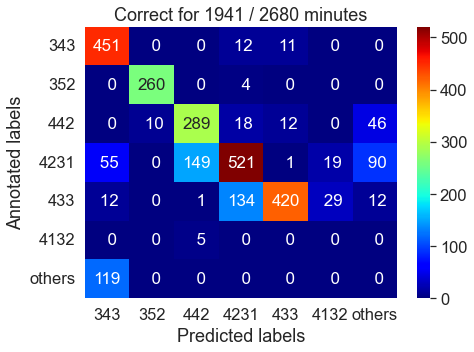

In [65]:
formations = ['343', '352', '442', '4231', '433', '4132', 'others']
minute_df_true[LABEL_FORMATION] = minute_df_true[LABEL_FORMATION].astype(str).apply(
    lambda x: x if x in formations[:-1] else 'others'
)

conf_mat = confusion_matrix(
    minute_df_true[LABEL_FORMATION].values,
    minute_df_pred[LABEL_FORMATION].values,
    labels=formations
)
conf_mat = pd.DataFrame(conf_mat, index=formations, columns=formations)
minute_df_common = pd.merge(minute_df_true, minute_df_pred)

plt.figure(figsize=(7, 5))
sns.set(font_scale=1.5)
sns.heatmap(conf_mat, cmap='jet', annot=True, fmt='3d', annot_kws={"size": 17,})
plt.title(f"Correct for {len(minute_df_common)} / {len(minute_df_true)} minutes")
plt.xlabel("Predicted labels")
plt.ylabel("Annotated labels")
plt.savefig('img/form_conf.pdf', bbox_inches='tight')

In [66]:
minute_df = pd.merge(minute_df_true, minute_df_pred, on=form_header[:3])
discords = minute_df[minute_df['formation_x'] != minute_df['formation_y']]
discords.groupby([LABEL_ACTIVITY_ID, LABEL_SESSION, 'formation_x', 'formation_y']).first().reset_index()

,activity_id,session,formation_x,formation_y,start_time
0,2310,1,4231,442,0
1,2310,2,4231,343,0
2,2310,2,433,343,42
3,5090,1,4231,others,39
4,5090,2,4231,others,0
5,5090,2,433,others,8
6,5420,1,4231,4132,0
7,5420,1,433,4132,19
8,5420,2,442,433,36
9,5458,1,others,343,0


### Compute the confusion matrix for role prediction

In [67]:
right_cols = HEADER_ROLE_RECORDS[:5] + [LABEL_FORMATION, LABEL_PLAYER_ID, LABEL_SQUAD_NUM, LABEL_ALIGNED_ROLE]
role_records = pd.read_csv('data/role_records.csv', header=0)
role_tags_pred = pd.merge(role_periods, role_records[right_cols])

In [68]:
activity_ids = role_tags_true[LABEL_ACTIVITY_ID].unique()
records = role_tags_pred[role_tags_pred[LABEL_ACTIVITY_ID].isin(activity_ids)].reset_index(drop=True)
minute_df_pred = generate_minute_segments(records, mode='role')
minute_df_pred

100%|██████████| 1505/1505 [00:04<00:00, 367.58it/s]


,activity_id,session,start_time,squad_num,aligned_role
0,2310,1,0,4,RCB
0,2310,1,0,7,LM
0,2310,1,0,14,LCF
0,2310,1,0,18,RCF
0,2310,1,0,19,LCM
...,...,...,...,...,...
38,21704,2,49,20,RCB
38,21704,2,49,21,RM
38,21704,2,49,23,LCF
38,21704,2,49,28,LCB


In [69]:
minute_df_true = generate_minute_segments(role_tags_true, mode='role')
minute_df_true = pd.merge(minute_df_pred[role_header[:-1]], minute_df_true)
minute_df_true

100%|██████████| 1718/1718 [00:04<00:00, 357.63it/s]


,activity_id,session,start_time,squad_num,aligned_role
0,2310,1,0,4,RCB
1,2310,1,0,7,LM
2,2310,1,0,14,CAM
3,2310,1,0,18,CF
4,2310,1,0,19,LDM
...,...,...,...,...,...
26647,21704,2,49,20,LCB
26648,21704,2,49,21,RM
26649,21704,2,49,23,LCF
26650,21704,2,49,28,RCB


In [70]:
np.sort(minute_df_pred[LABEL_ALIGNED_ROLE].unique())

array(['CAM', 'CB', 'CDM', 'CF', 'LB', 'LCB', 'LCF', 'LCM', 'LDM', 'LM',
       'LWB', 'RB', 'RCB', 'RCF', 'RCM', 'RDM', 'RM', 'RWB'], dtype=object)

Text(106.5, 0.5, 'Annotated labels')

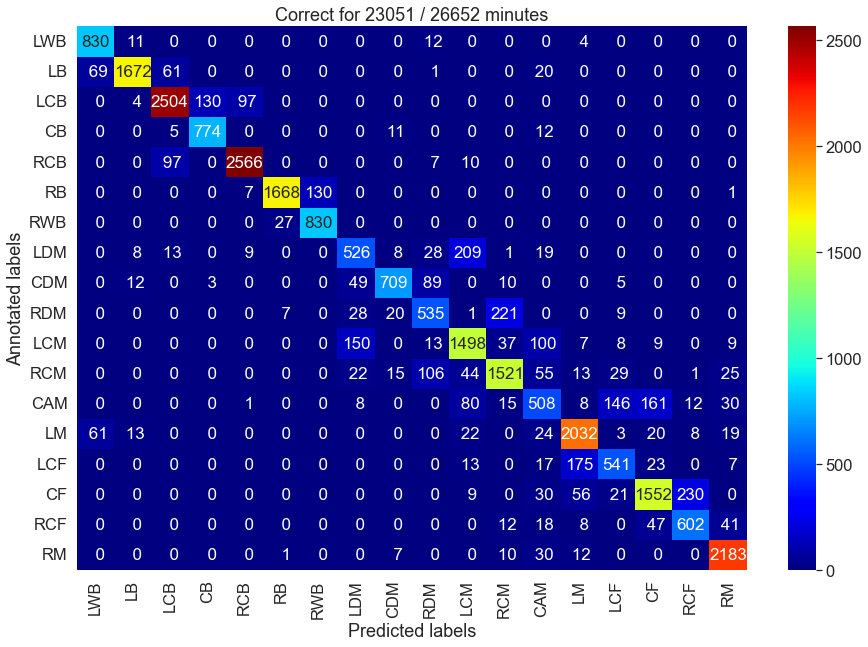

In [71]:
roles = [
    'LWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'RWB',
    'LDM', 'CDM', 'RDM', 'LCM', 'RCM', 'CAM',
    'LM', 'LCF', 'CF', 'RCF', 'RM'
]
conf_mat = confusion_matrix(
    minute_df_true[LABEL_ALIGNED_ROLE].values,
    minute_df_pred[LABEL_ALIGNED_ROLE].values,
    labels=roles
)
conf_mat = pd.DataFrame(conf_mat, index=roles, columns=roles)
minute_df_common = pd.merge(minute_df_true, minute_df_pred)

plt.figure(figsize=(15, 10))
sns.set(font_scale=1.5)
sns.heatmap(conf_mat, cmap='jet', annot=True, fmt='3d', annot_kws={"size": 17,})
plt.title(f"Correct for {len(minute_df_common)} / {len(minute_df_true)} minutes")
plt.xlabel("Predicted labels")
plt.ylabel("Annotated labels")

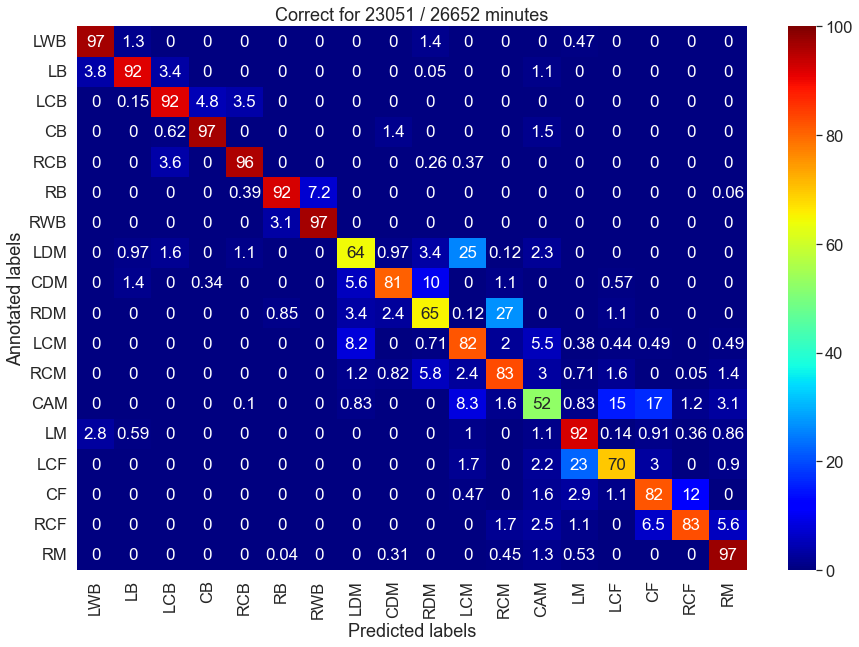

In [72]:
conf_mat = confusion_matrix(
    minute_df_true[LABEL_ALIGNED_ROLE].values,
    minute_df_pred[LABEL_ALIGNED_ROLE].values,
    labels=roles, normalize='true'
)
conf_mat = pd.DataFrame(conf_mat, index=roles, columns=roles).round(4) * 100
minute_df_common = pd.merge(minute_df_true, minute_df_pred)

plt.figure(figsize=(15, 10))
sns.set(font_scale=1.5)
sns.heatmap(conf_mat, vmin=0, vmax=100, cmap='jet', annot=True, annot_kws={"size": 17,})
plt.title(f"Correct for {len(minute_df_common)} / {len(minute_df_true)} minutes")
plt.xlabel("Predicted labels")
plt.ylabel("Annotated labels")
plt.savefig('img/role_conf.pdf', bbox_inches='tight')